# CNN for image classification in CIFAR-10<br>
CIFAR-10 : Consists 60000 32x32 color images in 10 classes, with 6000 images/class (50000 training and 10000 test).
10 classes :
<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>


In [14]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [16]:
#32 x 32 x 3 numpy array
x_train[333].shape

(32, 32, 3)

[3]


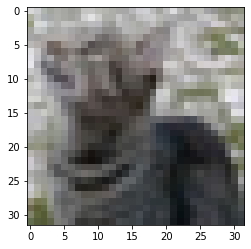

In [17]:
# view an image
print(y_train[333])
plt.imshow(x_train[333]);

In [18]:
# classes to 1X10 matrix
num_classes = 10
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
# sample test
y_train[333]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [19]:
# scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))

x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

## model_1: Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification <br>

In [20]:
model_1 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, activation='relu', strides = (2,2), padding='same',input_shape=x_train.shape[1:]), 
    keras.layers.Conv2D(32, kernel_size=5, activation='relu', strides = (2,2), ), 
    keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),  
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax'), 
])
model_1.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 16, 16, 32)        2432      
                                                                 
 conv2d_9 (Conv2D)           (None, 6, 6, 32)          25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 3, 3, 32)          0         
                                                                 
 flatten_2 (Flatten)         (None, 288)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               147968    
                                                      

In [21]:
from tensorflow.keras.optimizers import RMSprop
batch_size = 128

opt = RMSprop(learning_rate=0.0005, decay=1e-6)

model_1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=15,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/15
391/391 [==============================] - 3s 7ms/step - loss: 1.7356 - accuracy: 0.3679 - val_loss: 1.4365 - val_accuracy: 0.4837
Epoch 2/15
391/391 [==============================] - 2s 6ms/step - loss: 1.4515 - accuracy: 0.4796 - val_loss: 1.3122 - val_accuracy: 0.5268
Epoch 3/15
391/391 [==============================] - 2s 6ms/step - loss: 1.3353 - accuracy: 0.5222 - val_loss: 1.2252 - val_accuracy: 0.5648
Epoch 4/15
391/391 [==============================] - 2s 6ms/step - loss: 1.2605 - accuracy: 0.5495 - val_loss: 1.1448 - val_accuracy: 0.5964
Epoch 5/15
391/391 [==============================] - 2s 6ms/step - loss: 1.2023 - accuracy: 0.5698 - val_loss: 1.1215 - val_accuracy: 0.6030
Epoch 6/15
391/391 [==============================] - 2s 6ms/step - loss: 1.1575 - accuracy: 0.5877 - val_loss: 1.1432 - val_accuracy: 0.5959
Epoch 7/15
391/391 [==============================] - 2s 6ms/step - loss: 1.1163 - accuracy: 0.6046 - val_loss: 1.0570 - val_accuracy: 0.6247
Epoch 

In [22]:
score = model_1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9167316555976868
Test accuracy: 0.6837999820709229


## model_2: Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool ->(Flatten) -> Dense -> Final Classification

In [23]:

wdecay=1e-4
model_2 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3,padding='same', activation='relu',kernel_regularizer=keras.regularizers.l2(wdecay), input_shape=x_train.shape[1:]), 
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, kernel_size=3,padding='same', activation='relu',kernel_regularizer=keras.regularizers.l2(wdecay)), 
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(64, kernel_size=3,padding='same', activation='relu',kernel_regularizer=keras.regularizers.l2(wdecay)), 
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=3,padding='same', activation='relu',kernel_regularizer=keras.regularizers.l2(wdecay)), 
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, kernel_size=3,padding='same', activation='relu',kernel_regularizer=keras.regularizers.l2(wdecay)), 
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, kernel_size=3,padding='same', activation='relu',kernel_regularizer=keras.regularizers.l2(wdecay)), 
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    keras.layers.Dropout(0.4),
    
    keras.layers.Flatten(), 
    keras.layers.Dense(num_classes, activation='softmax'),
])
model_2.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [25]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 30:
        lrate = 0.0005
    if epoch > 70:
        lrate = 0.0003
    return lrate

datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

batch_size = 64  
epochs = 100

model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_2.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0]  // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(x_test,y_test),\
                    callbacks=[keras.callbacks.LearningRateScheduler(lr_schedule)])


Epoch 1/100
781/781 [==============================] - 35s 43ms/step - loss: 1.4239 - accuracy: 0.5467 - val_loss: 1.3129 - val_accuracy: 0.6013 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - 27s 34ms/step - loss: 1.1372 - accuracy: 0.6366 - val_loss: 1.0492 - val_accuracy: 0.6782 - lr: 0.0010
Epoch 3/100
781/781 [==============================] - 28s 35ms/step - loss: 0.9981 - accuracy: 0.6812 - val_loss: 0.9814 - val_accuracy: 0.7081 - lr: 0.0010
Epoch 4/100
781/781 [==============================] - 27s 34ms/step - loss: 0.9142 - accuracy: 0.7115 - val_loss: 0.7970 - val_accuracy: 0.7574 - lr: 0.0010
Epoch 5/100
781/781 [==============================] - 27s 34ms/step - loss: 0.8649 - accuracy: 0.7287 - val_loss: 0.7825 - val_accuracy: 0.7641 - lr: 0.0010
Epoch 6/100
781/781 [==============================] - 27s 35ms/step - loss: 0.8287 - accuracy: 0.7449 - val_loss: 0.7536 - val_accuracy: 0.7757 - lr: 0.0010
Epoch 7/100
781/781 [==============================]

In [26]:
score = model_2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4806486964225769
Test accuracy: 0.8791999816894531
